# Computer Vision CSCI-GA.2272-001 (Fall 2017)
## Assignment 2
## Lakshay Sharmal
## s4170@nyu.edu
## Submitted: Nov. 2, 2017

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/


## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [123]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import toimage
from PIL import Image
% matplotlib inline

In [26]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate
num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

In [22]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
def load_data(dataset):
    if dataset == 'mnist':
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
        testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)
        return (trainset, testset)

    elif dataset == 'cifar10':
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
        testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
        return (trainset, testset)

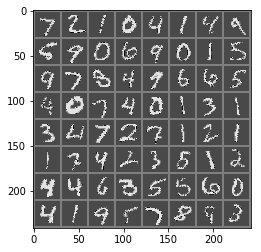

In [23]:
trainset, testset = load_data("mnist")
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    
for images, labels in test_loader:
    break
imshow(vutils.make_grid(images, nrow=8))

Files already downloaded and verified
Files already downloaded and verified
  dog  ship truck horse   cat  bird  bird  bird horse  ship plane   car  ship   cat horse   cat truck plane   cat  deer  bird  frog  ship  deer   dog   cat   dog   car  frog   cat plane truck  bird  bird plane  ship horse  ship truck plane  bird horse  bird  deer  deer   car   dog  bird horse  frog   cat  bird truck   dog  bird  deer   car   dog  frog  bird  bird   cat plane  ship


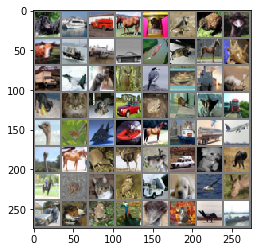

In [25]:
trainset, testset = load_data("cifar10")
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(vutils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

## Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

Solution:

** Define model **

In [67]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

**Define train and test functions**

In [96]:
def train(epoch):
    losses = []
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        losses.append(loss.data[0])
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    
    return losses

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    incorrect_perc = (len(test_loader.dataset) - correct) / len(test_loader.dataset)
    
    return incorrect_perc

In [44]:
dataset = "mnist"

trainset, testset = load_data("mnist")
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

In [45]:
network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

train_losses = []
test_err = []

for epoch in range(1, epochs + 1):
    train_losses.extend(train(epoch))
    test_err.append(test())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.551737
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.514252
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.455311
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.320106
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.417028
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.591826
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.370529
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.404086
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.322305
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.264194

Test set: Average loss: 0.3317, Accuracy: 9078/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.190337
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.173628
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.293654
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.382888
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.202076
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.335124
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.301532
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.266795
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.234789
T

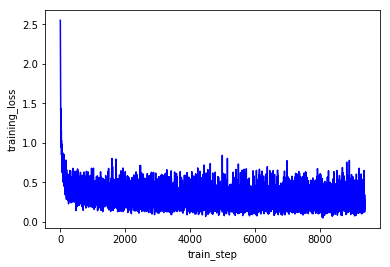

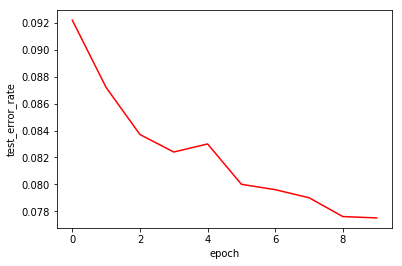

In [54]:
plt.plot(range(len(train_losses)), train_losses, 'b-')
plt.xlabel('train_step')
plt.ylabel('training_loss')
plt.show()

plt.plot(range(len(test_err)), test_err, 'r-')
plt.xlabel('epoch')
plt.ylabel('test_error_rate')
plt.show()


** Get weights **

In [56]:
nt = [i for i in network.children()][0].weight.data.numpy()

** Re-shape weights **

In [57]:
shaped_weights = np.zeros((10,28,28))
for i in range(10):
    shaped_weights[i] = nt.T[:,i].reshape((28,28))

** Visualize weights **

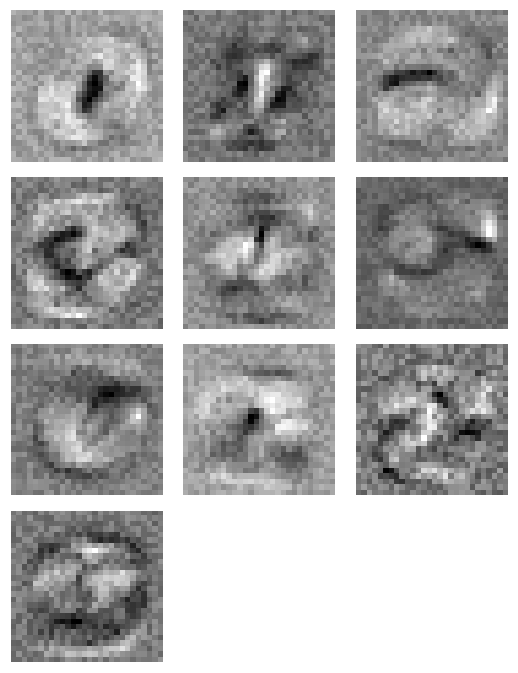

In [58]:
num_cols = 3
num_kernels = shaped_weights.shape[0]
num_rows = 1 +  num_kernels // num_cols
fig = plt.figure(figsize=(num_cols*3,num_rows*3))
for i in range(shaped_weights.shape[0]):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(shaped_weights[i], cmap="gray")
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

In [59]:
trainset, testset = load_data("mnist")
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [65]:
def train_50(epoch):
    losses = []
    network_50.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if (batch_idx >= 50):
            break
        data, target = Variable(data), Variable(target)
        optimizer_50.zero_grad()
        output = network_50(data)
        loss = F.cross_entropy(output, target)
        losses.append(loss.data[0])
        loss.backward()
        optimizer_50.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    
    return losses

def test_50():
    network_50.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network_50(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    incorrect_perc = (len(test_loader.dataset) - correct) / len(test_loader.dataset)
    
    return incorrect_perc



In [68]:
network_50 = Net(num_inputs, num_outputs)
optimizer_50 = optim.SGD(network_50.parameters(), lr=lr)

train_losses_50 = []
test_err_50 = []

for epoch in range(1, epochs + 1):
    train_losses_50.extend(train_50(epoch))
    test_err_50.append(test_50())

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.061224

Test set: Average loss: 1.6053, Accuracy: 5127/10000 (51%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.855928

Test set: Average loss: 1.2324, Accuracy: 6172/10000 (62%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.078427

Test set: Average loss: 1.2229, Accuracy: 6248/10000 (62%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.062712

Test set: Average loss: 1.2217, Accuracy: 6259/10000 (63%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.048783

Test set: Average loss: 1.2223, Accuracy: 6259/10000 (63%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.040434

Test set: Average loss: 1.2237, Accuracy: 6266/10000 (63%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.034803

Test set: Average loss: 1.2254, Accuracy: 6266/10000 (63%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.030704

Test set: Average loss: 1.2273, Accuracy: 6273/10000 (63%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.027561

Test set: Average loss: 1.2292, Accuracy: 6275/10000 (63%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.025061


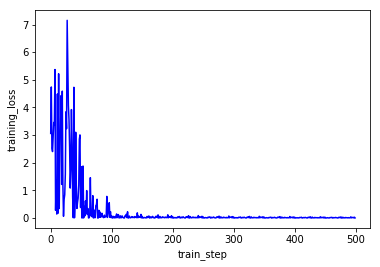

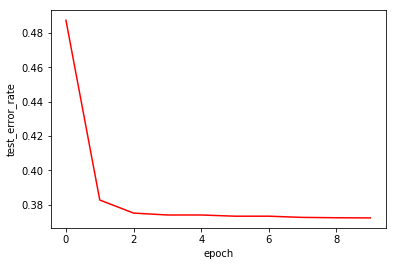

In [69]:
plt.plot(range(len(train_losses_50)), train_losses_50, 'b-')
plt.xlabel('train_step')
plt.ylabel('training_loss')
plt.show()

plt.plot(range(len(test_err_50)), test_err_50, 'r-')
plt.xlabel('epoch')
plt.ylabel('test_error_rate')
plt.show()


** Get weights **

In [72]:
nt_50 = [i for i in network_50.children()][0].weight.data.numpy()

** Re-shape weights **

In [73]:
shaped_weights_50 = np.zeros((10,28,28))
for i in range(10):
    shaped_weights_50[i] = nt_50.T[:,i].reshape((28,28))

** Visualize weights **

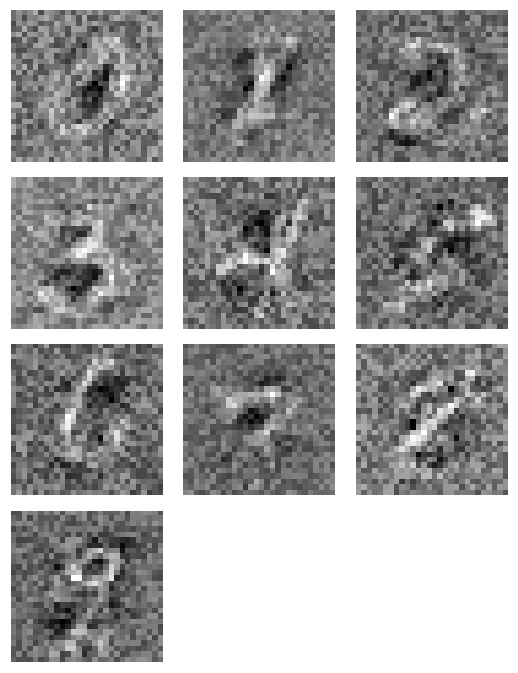

In [74]:
num_cols = 3
num_kernels = shaped_weights.shape[0]
num_rows = 1 +  num_kernels // num_cols
fig = plt.figure(figsize=(num_cols*3,num_rows*3))
for i in range(shaped_weights_50.shape[0]):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(shaped_weights_50[i], cmap="gray")
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
num_cols = 3
num_kernels = shaped_weights.shape[0]
num_rows = 1 +  num_kernels // num_cols
fig = plt.figure(figsize=(num_cols*3,num_rows*3))
for i in range(shaped_weights.shape[0]):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(shaped_weights[i], cmap="gray")
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a 'tanh' non-linearity. [Hint: modify the 'Net' class]. Train the model for 10 epochs and save the output into your report.

In [77]:
class NetMult(nn.Module):
    def __init__(self, num_inputs, hidden, num_outputs):
        super(NetMult, self).__init__()
        self.f1 = nn.Linear(num_inputs, hidden)
        self.tanh = nn.Tanh()
        self.f2 = nn.Linear(hidden, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        out = self.f1(x)
        out = self.tanh(out)
        out = self.f2(out)
        return out
    
hidden = 1000

In [81]:
trainset, testset = load_data("mnist")
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [87]:
network = NetMult(num_inputs, hidden, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

train_losses_mult = []
test_err_mult = []

for epoch in range(1, epochs + 1):
    train_losses_mult.extend(train(epoch))
    test_err_mult.append(test())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.388484
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.731987
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.729188
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.559306
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.425033
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.362436
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.436448
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.513907
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.482036
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.446488

Test set: Average loss: 0.3220, Accuracy: 9102/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.388993
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.246768
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.329256
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.402804
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.199814
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.194428
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.534657
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.193554
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.414643
T

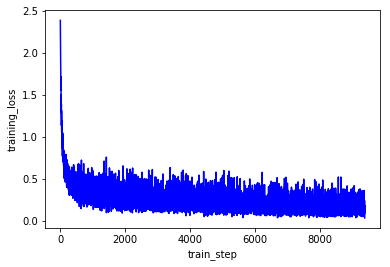

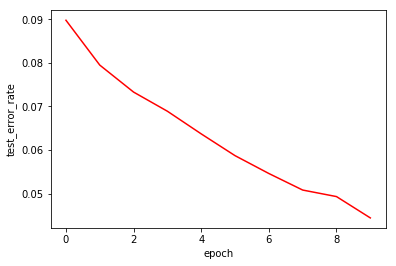

In [88]:
plt.plot(range(len(train_losses_mult)), train_losses_mult, 'b-')
plt.xlabel('train_step')
plt.ylabel('training_loss')
plt.show()

plt.plot(range(len(test_err_mult)), test_err_mult, 'r-')
plt.xlabel('epoch')
plt.ylabel('test_error_rate')
plt.show()


In [86]:
len(train_losses_mult)

10

-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation


In [89]:
network = NetMult(num_inputs, hidden, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=10)

train_losses_mult_2 = []
test_err_mult_2 = []

for epoch in range(1, epochs + 1):
    train_losses_mult_2.extend(train(epoch))
    test_err_mult_2.append(test())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324826
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1932.708984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1002.728760
Train Epoch: 1 [19200/60000 (32%)]	Loss: 979.345642
Train Epoch: 1 [25600/60000 (43%)]	Loss: 750.054443
Train Epoch: 1 [32000/60000 (53%)]	Loss: 988.878296
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1442.918823
Train Epoch: 1 [44800/60000 (75%)]	Loss: 387.142731
Train Epoch: 1 [51200/60000 (85%)]	Loss: 321.175720
Train Epoch: 1 [57600/60000 (96%)]	Loss: 190.585144

Test set: Average loss: 416.4678, Accuracy: 5765/10000 (58%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 361.851685
Train Epoch: 2 [6400/60000 (11%)]	Loss: 347.108032
Train Epoch: 2 [12800/60000 (21%)]	Loss: 568.938049
Train Epoch: 2 [19200/60000 (32%)]	Loss: 189.855972
Train Epoch: 2 [25600/60000 (43%)]	Loss: 133.120026
Train Epoch: 2 [32000/60000 (53%)]	Loss: 214.449295
Train Epoch: 2 [38400/60000 (64%)]	Loss: 173.962708
Train Epoch: 2 [44800/60000 (75%)]	Loss: 203.554001
Train Epoch:

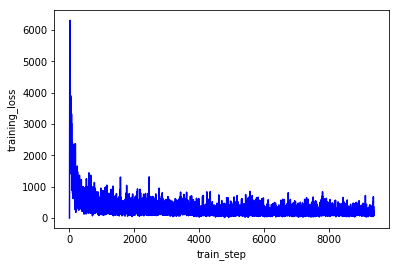

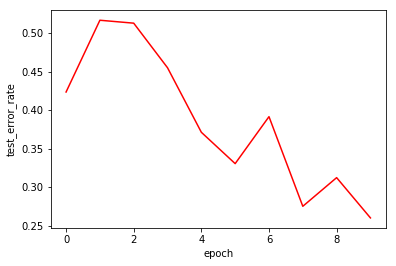

In [90]:
plt.plot(range(len(train_losses_mult_2)), train_losses_mult_2, 'b-')
plt.xlabel('train_step')
plt.ylabel('training_loss')
plt.show()

plt.plot(range(len(test_err_mult_2)), test_err_mult_2, 'r-')
plt.xlabel('epoch')
plt.ylabel('test_error_rate')
plt.show()


## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

In [95]:
dataset = "cifar10"

if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

epochs = 20
trainset, testset = load_data(dataset)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [103]:
class Net(nn.Module):
    
    def __init__ (self, num_outputs):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.fc1 = nn.Linear(128*5*5, 64)
        self.fc2 = nn.Linear(64, num_outputs)
        
    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        #can also write above parameters as (x, 2), since 2,2 is a square matrix/filter
        x = F.tanh(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [106]:
network = Net(num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

train_losses_cifar = []
test_err_cifar = []

for epoch in range(1, epochs + 1):
    train_losses_cifar.append(train(epoch))
    test_err_cifar.append(test())

    

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.310044
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.120241
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.212770
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.983636
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.873334
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.809986
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.840326
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.802574

Test set: Average loss: 1.8342, Accuracy: 17736/50000 (35%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.753505
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.823265
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.732599
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.854525
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.750319
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.749321
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.546424
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.464848

Test set: Average loss: 1.6199, Accuracy: 21156/50000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.540399
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.6

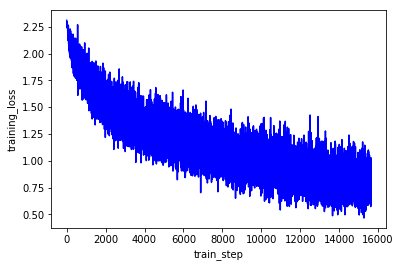

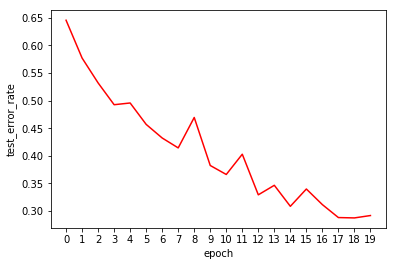

In [121]:
plt.plot(range(len(train_losses_cifar_2)), train_losses_cifar_2, 'b-')
plt.xlabel('train_step')
plt.ylabel('training_loss')
plt.show()

plt.plot(range(len(test_err_cifar)), test_err_cifar, 'r-')
plt.xlabel('epoch')
plt.ylabel('test_error_rate')
plt.xticks(range(len(test_err_cifar)))
plt.show()

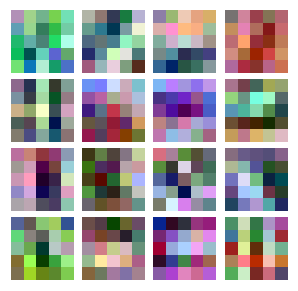

In [124]:
f1 = list(network.parameters())[0]

num_cols = 4
num_kernels = len(f1)
num_rows = 1 +  num_kernels // num_cols
fig = plt.figure(figsize=(num_cols*1.25,num_rows*1.25))
for i in range(len(f1)):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(toimage(f1[i].data.numpy()))               
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

Give a breakdown of the parameters within the above model, and the overall number.

• Convolution layer ($\texttt{conv1}$): has 16 3-channel convolution filters, each of dimension 5x5. Thereis a bias parameter for each of these 16 filters.

• Convolution layer ($\texttt{conv1}$):  has 128 16-channel convolution filters,  each of dimension 5x5.There is a bias parameter for each of these 128 filters.

• Linear layer ($\texttt{fc1}$):  takes as input a flattened vector of dimension 1x3200, and produces anoutput vector of dimension 1x64.  Thus, the parameter matrix for this layer has dimensions3200x64.  Each of the 64 outputs has an associated bias.

•Linear layer ($\texttt{fc2}$):  takes as input a flat vector of dimension 1x64, and produces an outputvector of dimension 1x10.  Thus,  the parameter matrix for this layer has dimension 64x10.Each of the 10 outputs has an associated bias.

The following table summarizes the total learned parameters in the model:


\begin{array}{||c | c c c||} 
    \hline
    Layer & Param-matrix & Biases & Total \\ 
    \hline \hline
    conv1 & 16*3*5*5 & 16 & 1,216 \\ 
    \hline
    conv2 & 128*16*5*5 & 128 & 51,328 \\
    \hline
    fc1 & 3200*64 & 64 & 204,864 \\
    \hline
    fc2 & 64*10 & 10 & 650 \\
    \hline \hline
    Overall &  &  & 258,058 \\ 
    \hline
\end{array}
